In [108]:
import torch
import pandas as pd
import esm
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    balanced_accuracy_score,
    ConfusionMatrixDisplay,
    mean_squared_error,
    classification_report,
)
from Bio import SeqIO
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold

In [2]:
EMB_PATH_PU = "./embeddings/pu"
EMB_PATH_NONPU = "./embeddings/nonpu"
EMB_UNKOWN = "./embeddings/unknown"

In [3]:
# Create folders for embeddings if they don't exist
os.makedirs(EMB_PATH_PU, exist_ok=True)
os.makedirs(EMB_PATH_NONPU, exist_ok=True)
os.makedirs(EMB_UNKOWN, exist_ok=True)

# Data Load


Open Non Core Pu file


In [4]:
with open("SET_PUs_NON_CORES (1).txt") as f:
    No_Pu = f.readlines()

for i in range(len(No_Pu)):
    No_Pu[i] = No_Pu[i].strip()

Open Fasta data


In [5]:
fasta_file = "DB_PU_NONPU_SEQ.fasta"
fasta_sequence = []
with open(fasta_file, "r") as f:
    for record in SeqIO.parse(f, "fasta"):
        fasta_sequence.append(record)

Open Pu File


In [6]:
Pu = pd.read_table(
    "LISTS_CATFS_PU_PROTOTYPE_with_fused_famillies (1)", sep="\t", header=None
)

In [7]:
data = []
for line in Pu[0]:
    liste = []

    line = line.split(" ")
    for element in line:
        if element != "":
            liste.append(element)
    data.append(liste)

In [8]:
CLASS = []
ARCHITECTURE = []
TOPOLOGY = []
NANOFOLD = []
FREQUENCY = []
PROTO_FOLD_PROTOTYPE = []
PU_FAMILY_MEMBERS_CATEGORY = []
for element in data[7:]:
    CLASS.append(element[0])
    ARCHITECTURE.append(element[1])
    TOPOLOGY.append(element[2])
    NANOFOLD.append(element[3])
    FREQUENCY.append(element[4])
    PROTO_FOLD_PROTOTYPE.append(element[5])
    PU_FAMILY_MEMBERS_CATEGORY.append(element[6:])

In [9]:
for i in range(len(PU_FAMILY_MEMBERS_CATEGORY)):
    PU_FAMILY_MEMBERS_CATEGORY[i][0] = PU_FAMILY_MEMBERS_CATEGORY[i][0].split(":")[1]

In [10]:
d = {
    "CLASS": CLASS,
    "ARCHITECTURE": ARCHITECTURE,
    "TOPOLOGY": TOPOLOGY,
    "NANOFOLD": NANOFOLD,
    "FREQUENCY": FREQUENCY,
    "PROTO_FOLD_PROTOTYPE": PROTO_FOLD_PROTOTYPE,
    "PU_FAMILY_MEMBERS_CATEGORY": PU_FAMILY_MEMBERS_CATEGORY,
}

In [11]:
Pu_families = pd.DataFrame(data=d)

In [12]:
Pu_families.head()

,CLASS,ARCHITECTURE,TOPOLOGY,NANOFOLD,FREQUENCY,PROTO_FOLD_PROTOTYPE,PU_FAMILY_MEMBERS_CATEGORY
0,Alpha-beta,bab,bUaUb,35.g306,9,1MJNA_2_127_163,"[1U14A_2_1_37, 2WW8A_12_487_525, 2DZXA_4_82_11..."
1,All-alpha,a,a,30.g147,91,2EO5A_10_78_103,"[2EO5A_10_78_103, 3QVQA_7_118_144, 3V7NA_14_35..."
2,All-alpha,a,a,20.g594,5,1YBTA_1_16_34,"[3JSZA_14_357_376, 3A24A_10_525_542, 1YBTA_1_1..."
3,Alpha-beta,aba,aUbLa,35.g162,157,1YISA_10_258_288,"[3K7XA_10_267_294, 4G10A_4_105_133, 3C3RA_10_2..."
4,Alpha-beta,baba,bUaUbLa,45.g94,31,3ICSA_11_510_555,"[2HHGA_2_86_132, 3SNKA_1_1_48, 2UUUA_6_300_347..."


Set data labels


In [13]:
Sequence = []
Is_pu = []
file = []
for record in fasta_sequence:
    Sequence.append(str(record.seq))
    file_name = f'{record.id}_{record.description.split("|")[1].split(" ")[1].split(":")[1]}_{record.description.split("|")[2].split(" ")[1].split(":")[1]}_{record.description.split("|")[3].split(" ")[1].split(":")[1]}'
    file.append(file_name)
    if file_name in No_Pu:
        Is_pu.append(0)
    elif file_name in Pu_families["PROTO_FOLD_PROTOTYPE"].values:
        Is_pu.append(1)
    else:
        Is_pu.append(2)

In [14]:
d = {"Sequence": Sequence, "Is_pu": Is_pu, "file": file}

In [15]:
seq_data = pd.DataFrame(data=d)

In [16]:
seq_data.head()

,Sequence,Is_pu,file
0,DGERQFSTLKSTVEAIWAG,2,12ASA_10_122_140
1,AYIAKQRQISFVKSHFSRQLEERL,2,12ASA_10_1_24
2,IKATEAAVSEEFGLAP,2,12ASA_10_141_156
3,FLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLV,2,12ASA_10_157_196
4,GIGGKLSDGHRHDVRA,2,12ASA_10_197_212


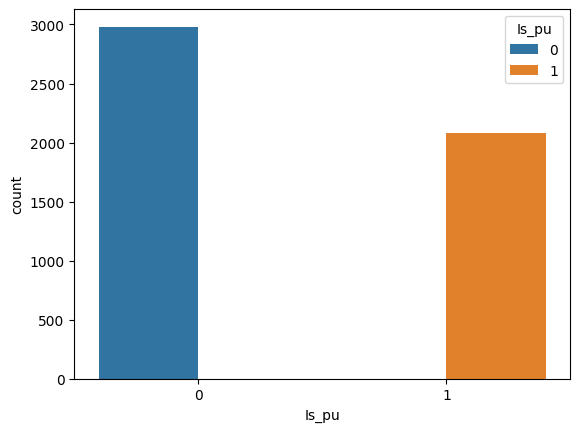

In [17]:
# Count on pu and non pu


sns.countplot(x="Is_pu", data=seq_data.loc[(seq_data["Is_pu"] != 2)], hue="Is_pu")
plt.show()

In [18]:
# count is_pu=2 and plot value using pandas
print(
    "unkown %d\npu %d\nnon-pu %d"
    % (
        seq_data.loc[(seq_data["Is_pu"] == 2)]["Is_pu"].count(),
        seq_data.loc[(seq_data["Is_pu"] == 1)]["Is_pu"].count(),
        seq_data.loc[(seq_data["Is_pu"] == 0)]["Is_pu"].count(),
    )
)

unkown 1051653
pu 2081
non-pu 2981


# Embedding


Data for embedding


In [19]:
pre_emb_pu = seq_data.loc[(seq_data["Is_pu"] == 1)][["Sequence", "file"]]
pre_emb_nonpu = seq_data.loc[(seq_data["Is_pu"] == 0)][["Sequence", "file"]]

Transformers


In [103]:
def embedding_preparation(pre_emb, EMB_PATH):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    for line in pre_emb.values:
        # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)

        data = [(line[1], line[0])]

        batch_labels, batch_strs, batch_tokens = batch_converter(data)

        batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

        # Extract per-residue representations (on CPU)

        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)

            torch.save(results, f"{EMB_PATH}/{line[1]}.pt")

In [37]:
embedding_preparation(pre_emb_pu, EMB_PATH_PU)
embedding_preparation(pre_emb_nonpu, EMB_PATH_NONPU)

# Dataset preparation


In [20]:
def padding(tensor, max_size):
    if tensor.numpy().shape[0] < max_size:
        padding = max_size - tensor.numpy().shape[0]
        tensor = tf.pad(tensor, ((0, padding), (0, 0)))
    return tensor

In [21]:
# List of all embeddings
def get_embedding_list(PATH, label, max_size):
    list_of_embeddings = []
    for filename in os.listdir(PATH):
        embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][
            33
        ][0]

        embedding_tensor = tf.convert_to_tensor(embedding_dict)
        embedding_tensor = padding(embedding_tensor, max_size)
        list_of_embeddings.append(embedding_tensor)
    return list_of_embeddings, [label] * len(list_of_embeddings)

In [22]:
batch_size = 150

In [23]:
pd_non_pu, label_non_pu = get_embedding_list(EMB_PATH_NONPU, 0, 62)
pd_pu, label_pu = get_embedding_list(EMB_PATH_PU, 1, 62)

In [24]:
embeddings = pd_non_pu + pd_pu
labels = label_non_pu + label_pu

In [25]:
print(embeddings[0])

tf.Tensor(
[[ 4.9210332e-02  1.4223444e-02 -5.0694294e-02 ... -3.0550587e-01
   2.3493481e-01 -1.4564994e-01]
 [ 1.5709296e-02  1.3455091e-02  3.3007156e-02 ...  7.8282535e-02
   1.2138317e-01  1.6710907e-04]
 [ 5.5935629e-02  8.7842695e-02  1.1524474e-01 ...  4.7444843e-02
   3.5048194e-02 -1.7099097e-01]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]], shape=(62, 1280), dtype=float32)


In [62]:
print(labels[0])

0


In [63]:
# Split data into train and validation
from sklearn.model_selection import train_test_split

train_val_set, test_set, train_val_labels, test_labels = train_test_split(
    embeddings, labels, test_size=0.1, random_state=31, stratify=labels
)
train_set, val_set, train_labels, val_labels = train_test_split(
    train_val_set,
    train_val_labels,
    test_size=0.2,
    random_state=31,
    stratify=train_val_labels,
)

In [28]:
def conv_data(data, labels):
    return tf.data.Dataset.from_tensor_slices((data, labels))

In [29]:
def prep_data(train, lab, batch_size):
    tf_dataset = conv_data(train, lab)
    tf_dataset = tf_dataset.batch(batch_size)
    tf_dataset = tf_dataset.prefetch(tf.data.AUTOTUNE)
    return tf_dataset

In [64]:
tf_dataset = prep_data(train_set, train_labels, batch_size)
tf_val_dataset = prep_data(val_set, val_labels, batch_size)
tf_test_dataset = prep_data(test_set, test_labels, batch_size)

# Tensorflow model:

Protein classification


In [356]:
# Compute class weights


class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(train_labels), y=train_labels
)
class_weights = dict(enumerate(class_weights))

In [357]:
model_tf = tf.keras.Sequential(
    [
        tf.keras.layers.Input(shape=(62, 1280)),
        tf.keras.layers.GRU(50, return_sequences=True, dropout=0.3),
        tf.keras.layers.GRU(20, return_sequences=True, dropout=0.1),
        tf.keras.layers.GRU(10, dropout=0.2),
        tf.keras.layers.Dense(2, activation="softmax"),
    ]
)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf.summary()
model_tf.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_76 (GRU)                (None, 62, 50)            199800    
                                                                 
 gru_77 (GRU)                (None, 62, 20)            4320      
                                                                 
 gru_78 (GRU)                (None, 10)                960       
                                                                 
 dense_44 (Dense)            (None, 2)                 22        
                                                                 
Total params: 205102 (801.18 KB)
Trainable params: 205102 (801.18 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [358]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

model_tf.fit(
    tf_dataset,
    epochs=500,
    validation_data=tf_val_dataset,
    callbacks=callback,
    class_weight=class_weights,
    batch_size=batch_size,
)

Epoch 1/500
25/25 [==============================] - 13s 281ms/step - loss: 0.6958 - accuracy: 0.5318 - val_loss: 0.6924 - val_accuracy: 0.5708
Epoch 2/500
25/25 [==============================] - 5s 207ms/step - loss: 0.6901 - accuracy: 0.5941 - val_loss: 0.6897 - val_accuracy: 0.5906
Epoch 3/500
25/25 [==============================] - 5s 210ms/step - loss: 0.6873 - accuracy: 0.6010 - val_loss: 0.6889 - val_accuracy: 0.4995
Epoch 4/500
25/25 [==============================] - 6s 252ms/step - loss: 0.6841 - accuracy: 0.4940 - val_loss: 0.6890 - val_accuracy: 0.4654
Epoch 5/500
25/25 [==============================] - 7s 269ms/step - loss: 0.6817 - accuracy: 0.4819 - val_loss: 0.6884 - val_accuracy: 0.4632
Epoch 6/500
25/25 [==============================] - 6s 242ms/step - loss: 0.6781 - accuracy: 0.4896 - val_loss: 0.6873 - val_accuracy: 0.4819
Epoch 7/500
25/25 [==============================] - 6s 244ms/step - loss: 0.6755 - accuracy: 0.5019 - val_loss: 0.6865 - val_accuracy: 0.491

In [351]:
def plot_history(history, metric):
    plt.plot(history.history[f"{metric}"])
    plt.plot(history.history[f"val_{metric}"])
    plt.title(f"model {metric}")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylabel(f"{metric}")
    plt.xlabel("epoch")
    plt.show()

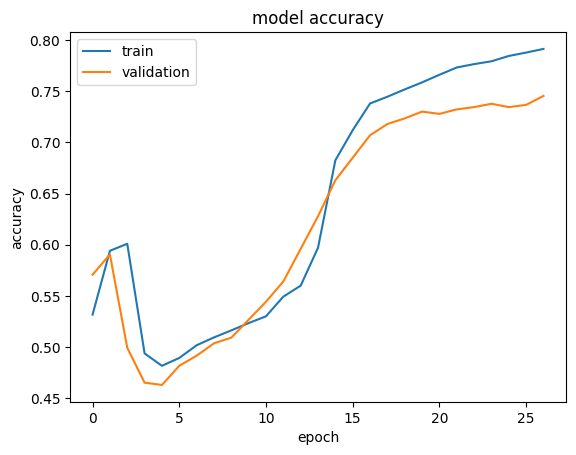

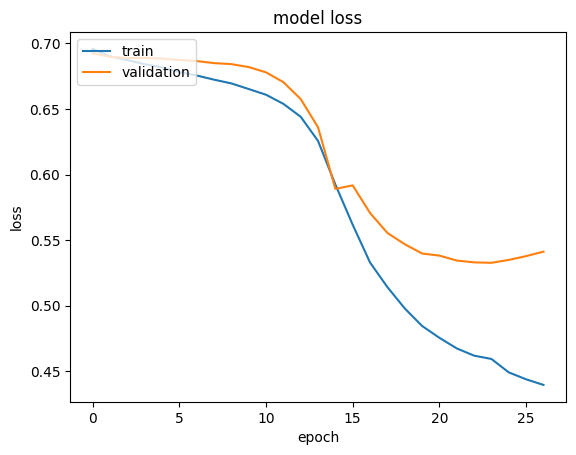

In [359]:
plot_history(model_tf.history, "accuracy")
plot_history(model_tf.history, "loss")

4/4 [==============================] - 1s 56ms/step


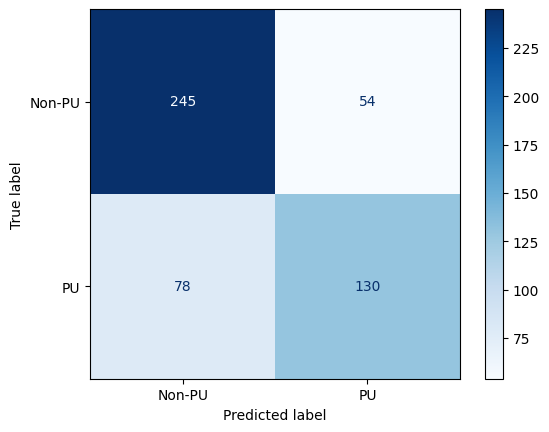

In [360]:
ConfusionMatrixDisplay.from_predictions(
    test_labels,
    model_tf.predict(tf_test_dataset).argmax(axis=1),
    cmap="Blues",
    display_labels=["Non-PU", "PU"],
)
plt.show()

4/4 [==============================] - 0s 57ms/step


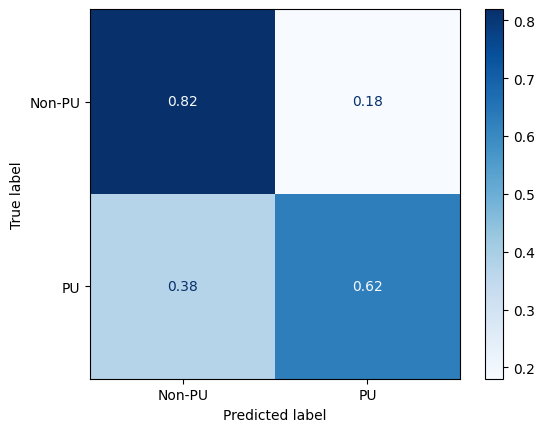

In [361]:
ConfusionMatrixDisplay.from_predictions(
    test_labels,
    model_tf.predict(tf_test_dataset).argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

In [363]:
# Compute balanced accuracy

print(
    "Balanced accuracy: %0.2f"
    % balanced_accuracy_score(
        test_labels, model_tf.predict(tf_test_dataset).argmax(axis=1)
    ),
)

# Compute MSE

print(
    "MSE: %0.2f"
    % mean_squared_error(test_labels, model_tf.predict(tf_test_dataset).argmax(axis=1))
)

# classification report

print(
    classification_report(test_labels, model_tf.predict(tf_test_dataset).argmax(axis=1))
)

4/4 [==============================] - 0s 73ms/step
Balanced accuracy: 0.72
4/4 [==============================] - 0s 63ms/step
MSE: 0.26
4/4 [==============================] - 0s 60ms/step
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       299
           1       0.71      0.62      0.66       208

    accuracy                           0.74       507
   macro avg       0.73      0.72      0.73       507
weighted avg       0.74      0.74      0.74       507



In [38]:
def map_labels(labels):
    liste = []
    mapped = {0: "Non-PU", 1: "PU"}
    for element in labels:
        liste.append(mapped[element])
    return liste

1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 79ms/step


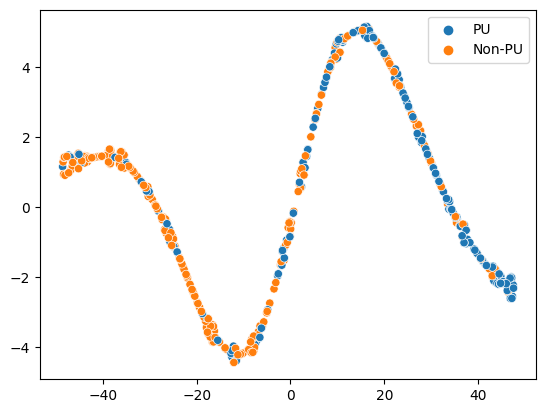

In [39]:
best_red_tsne = TSNE(
    n_components=2, learning_rate="auto", init="pca", random_state=42
).fit_transform(model_tf.predict(tf_test_dataset))


sns.scatterplot(
    x=best_red_tsne[:, 0], y=best_red_tsne[:, 1], hue=map_labels(test_labels)
)


plt.show()

Cross validation


In [90]:
# K-fold cross validation

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
score_acc = []
score_mse = []
pred_list = []
train_val_set_fold = np.array(train_val_set)
train_val_labels_fold = np.array(train_val_labels)
for val, train in kfold.split(train_val_set_fold, train_val_labels_fold):
    model_tf = tf.keras.Sequential(
        [
            tf.keras.layers.Input(shape=(62, 1280)),
            tf.keras.layers.GRU(50, return_sequences=True, dropout=0.3),
            tf.keras.layers.GRU(20, return_sequences=True, dropout=0.1),
            tf.keras.layers.GRU(10, dropout=0.2),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )
    class_weights_fold = compute_class_weight(
        class_weight="balanced",
        classes=np.unique(train_val_labels_fold[train]),
        y=train_val_labels_fold[train],
    )
    optimizer_fold = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model_tf.compile(
        optimizer=optimizer_fold,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    class_weights_fold = dict(enumerate(class_weights_fold))
    callback_fold = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
    model_tf.fit(
        prep_data(train_val_set_fold[val], train_val_labels_fold[val], batch_size),
        epochs=500,
        validation_data=prep_data(
            train_val_set_fold[train], train_val_labels_fold[train], batch_size
        ),
        callbacks=callback_fold,
        batch_size=batch_size,
        class_weight=class_weights_fold,
        verbose=0,
    )
    # Compute prediction
    predictions = model_tf.predict(tf_test_dataset)
    pred_list.append(predictions)
    # Compute balanced accuracy
    score_kfold = balanced_accuracy_score(
        test_labels, model_tf.predict(tf_test_dataset).argmax(axis=1)
    )
    score_acc.append(score_kfold)
    print("Balanced accuracy: %0.2f" % score_kfold)

    # Compute MSE
    score_kfold = mean_squared_error(
        test_labels, model_tf.predict(tf_test_dataset).argmax(axis=1)
    )
    score_mse.append(score_kfold)
    print("MSE: %0.2f" % score_kfold)

4/4 [==============================] - 1s 102ms/step
Balanced accuracy: 0.74
4/4 [==============================] - 0s 90ms/step
MSE: 0.25
4/4 [==============================] - 1s 166ms/step
Balanced accuracy: 0.75
4/4 [==============================] - 1s 124ms/step
MSE: 0.24
4/4 [==============================] - 1s 121ms/step
Balanced accuracy: 0.72
4/4 [==============================] - 1s 128ms/step
MSE: 0.26
4/4 [==============================] - 0s 114ms/step
Balanced accuracy: 0.72
4/4 [==============================] - 1s 117ms/step
MSE: 0.26
4/4 [==============================] - 1s 131ms/step
Balanced accuracy: 0.74
4/4 [==============================] - 1s 119ms/step
MSE: 0.25


In [91]:
# compute mean score
print("Mean balanced accuracy: %0.2f" % np.mean(score_acc))
print("Mean MSE: %0.2f" % np.mean(score_mse))

Mean balanced accuracy: 0.73
Mean MSE: 0.25


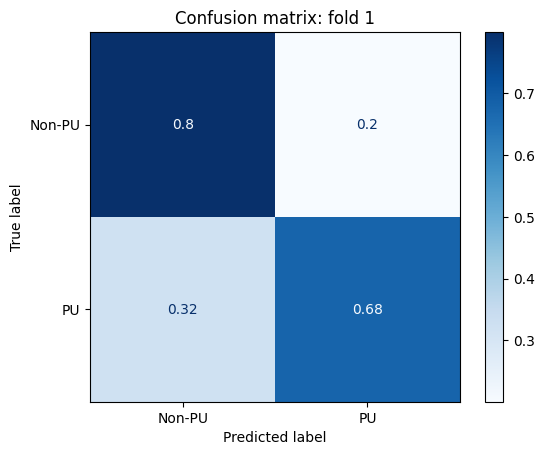

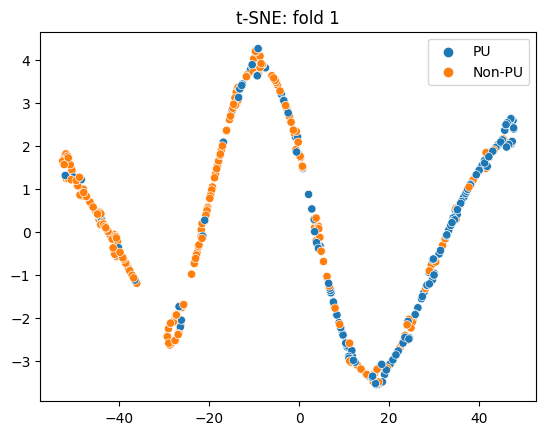

              precision    recall  f1-score   support

           0       0.78      0.80      0.79       299
           1       0.70      0.68      0.69       208

    accuracy                           0.75       507
   macro avg       0.74      0.74      0.74       507
weighted avg       0.75      0.75      0.75       507



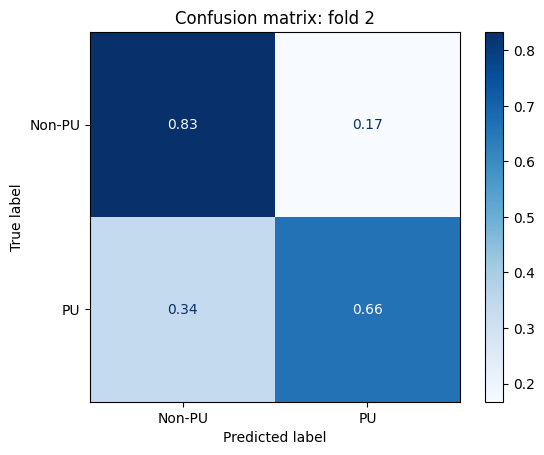

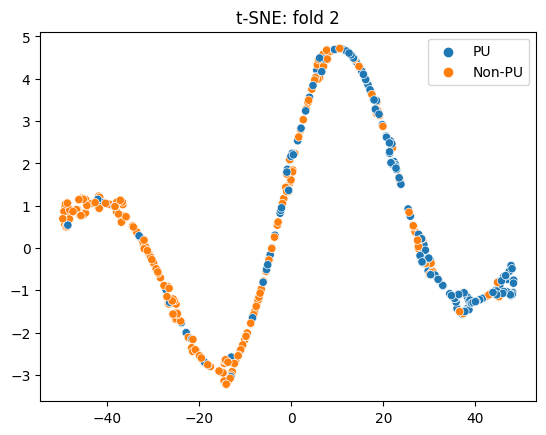

              precision    recall  f1-score   support

           0       0.78      0.83      0.81       299
           1       0.73      0.66      0.70       208

    accuracy                           0.76       507
   macro avg       0.76      0.75      0.75       507
weighted avg       0.76      0.76      0.76       507



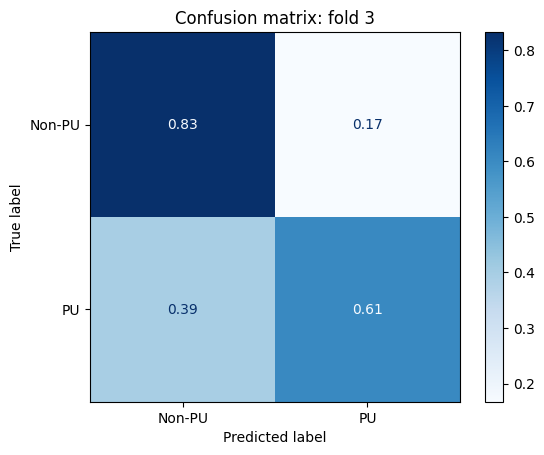

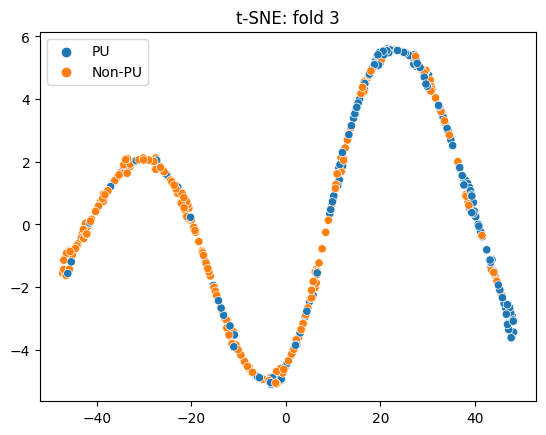

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       299
           1       0.72      0.61      0.66       208

    accuracy                           0.74       507
   macro avg       0.73      0.72      0.72       507
weighted avg       0.74      0.74      0.74       507



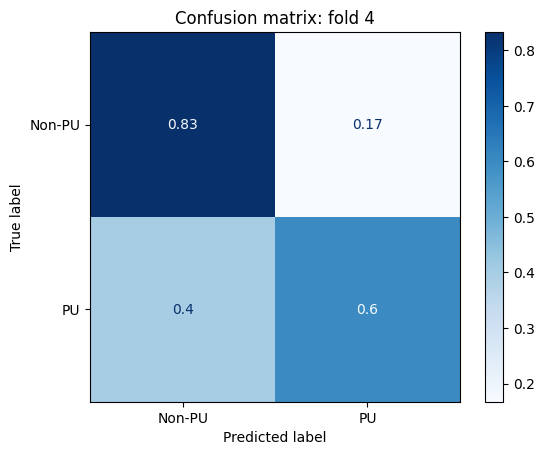

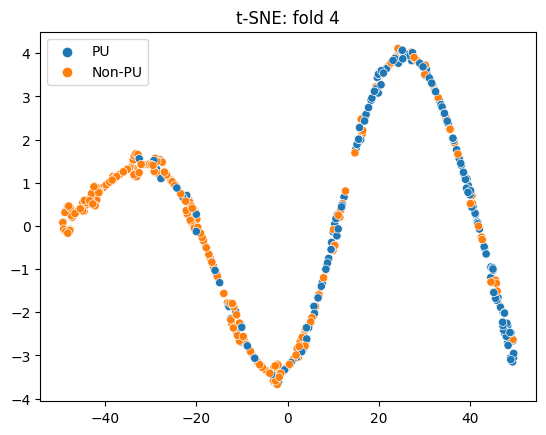

              precision    recall  f1-score   support

           0       0.75      0.83      0.79       299
           1       0.71      0.60      0.65       208

    accuracy                           0.74       507
   macro avg       0.73      0.72      0.72       507
weighted avg       0.74      0.74      0.73       507



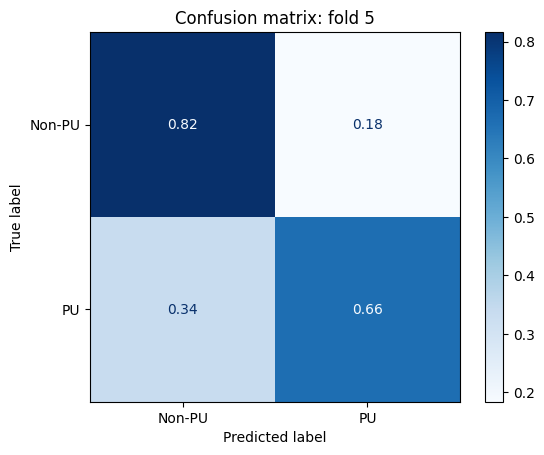

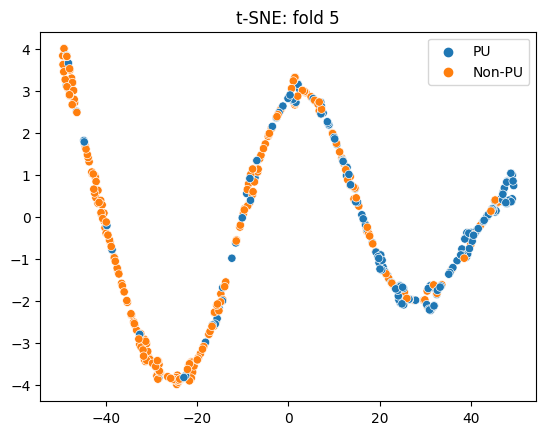

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       299
           1       0.72      0.66      0.69       208

    accuracy                           0.75       507
   macro avg       0.75      0.74      0.74       507
weighted avg       0.75      0.75      0.75       507



In [109]:
for i, pred in enumerate(pred_list):
    # Confusion matrix

    ConfusionMatrixDisplay.from_predictions(
        test_labels,
        pred.argmax(axis=1),
        cmap="Blues",
        normalize="true",
        display_labels=["Non-PU", "PU"],
    )
    plt.title("Confusion matrix: fold {}".format(i + 1))
    plt.show()
    # t-SNE
    tsne_fold = TSNE(
        n_components=2, learning_rate="auto", init="pca", random_state=42
    ).fit_transform(pred)
    sns.scatterplot(x=tsne_fold[:, 0], y=tsne_fold[:, 1], hue=map_labels(test_labels))
    plt.title("t-SNE: fold {}".format(i + 1))
    plt.show()
    # specificity and sensitivity
    print(classification_report(test_labels, pred.argmax(axis=1)))

Application


In [45]:
def is_pu_from_file(PATH, filename):
    embedding_dict = torch.load(os.path.join(PATH, filename))["representations"][33][0]

    embedding_tensor = tf.convert_to_tensor(embedding_dict)
    embedding_tensor = padding(embedding_tensor, 62)
    res = model_tf.predict(embedding_tensor[None,]).argmax(axis=1)[0]
    print("PU\npred = ", res) if res == 1 else print("Non-PU\npred = ", res)

In [46]:
def is_pu_from_seq(seq, name):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

    batch_converter = alphabet.get_batch_converter()

    model.eval()  # disables dropout for deterministic results

    # Prepare data
    data = [(name, seq)]

    batch_labels, batch_strs, batch_tokens = batch_converter(data)

    batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Extract per-residue representations (on CPU)

    with torch.no_grad():
        results = model(batch_tokens, repr_layers=[33], return_contacts=True)
    embedding_dict = results["representations"][33][0]

    embedding_tensor = tf.convert_to_tensor(embedding_dict)
    embedding_tensor = padding(embedding_tensor, 62)
    res = model_tf.predict(embedding_tensor[None,]).argmax(axis=1)[0]
    print("PU\npred = ", res) if res == 1 else print("Non-PU\npred = ", res)

In [47]:
is_pu_from_file(EMB_PATH_PU, "1A0CA_12_310_329.pt")

1/1 [==============================] - 1s 1s/step
PU
pred =  1


In [48]:
is_pu_from_file(EMB_PATH_NONPU, "1A0TP_10_23_44.pt")

1/1 [==============================] - 0s 46ms/step
Non-PU
pred =  0


In [49]:
seq_data.loc[(seq_data["file"] == "12ASA_10_213_228")]

,Sequence,Is_pu,file
5,PDYDDWSTPSELGHAG,2,12ASA_10_213_228


In [50]:
is_pu_from_seq("PDYDDWSTPSELGHAG", "12ASA_10_213_228")

1/1 [==============================] - 0s 54ms/step
Non-PU
pred =  0


Get last hidden layer of GRU


In [51]:
inputs = tf.keras.layers.Input(shape=(62, 1280))
GRU = tf.keras.layers.GRU(50, return_sequences=True, dropout=0.3)(inputs)
GRU2 = tf.keras.layers.GRU(20, return_sequences=True, dropout=0.1)(GRU)
GRU3, state_h = tf.keras.layers.GRU(10, return_state=True, dropout=0.2)(GRU2)
output = tf.keras.layers.Dense(2, activation="softmax")(GRU3)
model_tf2 = tf.keras.Model(inputs=inputs, outputs=[output, state_h])
model_tf2.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_tf2.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 62, 1280)]        0         
                                                                 
 gru_3 (GRU)                 (None, 62, 50)            199800    
                                                                 
 gru_4 (GRU)                 (None, 62, 20)            4320      
                                                                 
 gru_5 (GRU)                 [(None, 10),              960       
                              (None, 10)]                        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 205102 (801.18 KB)
Trainable params: 205102 (801.18 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

model_tf2.fit(
    tf_dataset,
    epochs=500,
    validation_data=tf_test_dataset,
    class_weight=class_weights,
    batch_size=batch_size,
    callbacks=callback,
)

Epoch 1/500
25/25 [==============================] - 18s 409ms/step - loss: 2.1452 - dense_1_loss: 0.6933 - gru_5_loss: 1.4519 - dense_1_accuracy: 0.5499 - gru_5_accuracy: 0.5316 - val_loss: 1.5711 - val_dense_1_loss: 0.6933 - val_gru_5_loss: 0.8778 - val_dense_1_accuracy: 0.5499 - val_gru_5_accuracy: 0.5862
Epoch 2/500
25/25 [==============================] - 8s 327ms/step - loss: 1.5646 - dense_1_loss: 0.6943 - gru_5_loss: 0.8704 - dense_1_accuracy: 0.5406 - gru_5_accuracy: 0.5576 - val_loss: 1.4124 - val_dense_1_loss: 0.6932 - val_gru_5_loss: 0.7192 - val_dense_1_accuracy: 0.5467 - val_gru_5_accuracy: 0.5851
Epoch 3/500
25/25 [==============================] - 8s 326ms/step - loss: 1.4703 - dense_1_loss: 0.6942 - gru_5_loss: 0.7761 - dense_1_accuracy: 0.5203 - gru_5_accuracy: 0.5738 - val_loss: 1.3991 - val_dense_1_loss: 0.6932 - val_gru_5_loss: 0.7059 - val_dense_1_accuracy: 0.5401 - val_gru_5_accuracy: 0.5884
Epoch 4/500
25/25 [==============================] - 9s 366ms/step - los

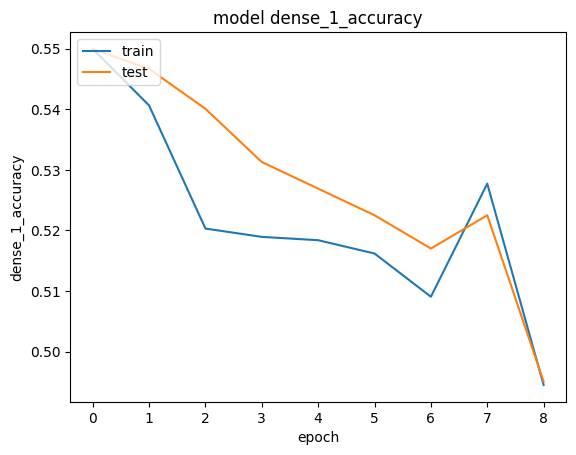

In [53]:
plot_history(model_tf2.history, "dense_1_accuracy")

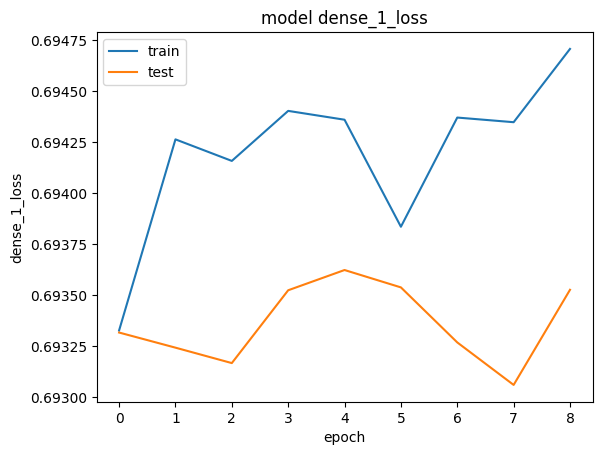

In [54]:
plot_history(model_tf2.history, "dense_1_loss")

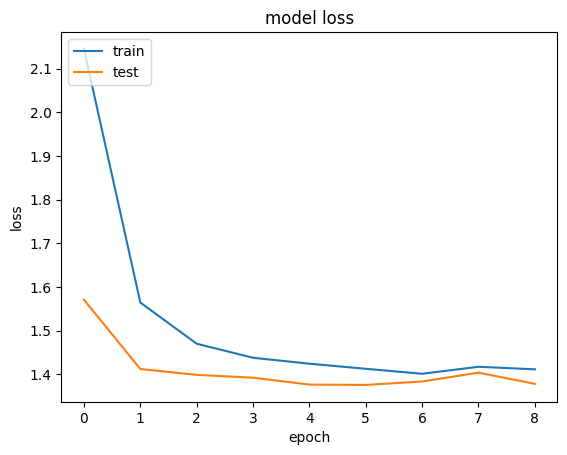

In [55]:
plot_history(model_tf2.history, "loss")

4/4 [==============================] - 1s 78ms/step


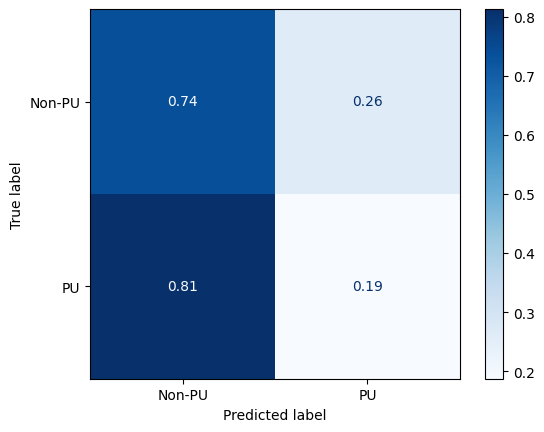

In [56]:
ConfusionMatrixDisplay.from_predictions(
    val_labels,
    model_tf2.predict(tf_val_dataset)[0].argmax(axis=1),
    cmap="Blues",
    normalize="true",
    display_labels=["Non-PU", "PU"],
)
plt.show()

UNKNOWN


In [ ]:
unknown = seq_data.loc[(seq_data["Is_pu"] == 2)][["Sequence", "file"]]

In [ ]:
embedding_preparation(unknown, EMB_UNKOWN)

In [ ]:
is_pu_from_file(EMB_UNKOWN, "1A0CA_1_1_385.pt")

1/1 [==============================] - 0s 489ms/step
Non-PU
pred =  0


In [ ]:
tensor_unknown = tf.convert_to_tensor(
    torch.load(EMB_UNKOWN + "/1A0CA_1_1_385.pt")["representations"][33][0]
)

In [43]:
set_unknown = tf.data.Dataset.from_tensor_slices(
    (tensor_unknown, [2] * len(tensor_unknown))
)
set_unknown = set_unknown.batch(128)
set_unknown = set_unknown.prefetch(tf.data.AUTOTUNE)

In [46]:
len(set_unknown)

4

famille PU MODEL


In [96]:
columns = [
    "CLASS",
    "ARCHITECTURE",
    "TOPOLOGY",
    "NANOFOLD",
    "PROTO_FOLD_PROTOTYPE",
]

In [97]:
data_category = Pu_families[columns]

In [98]:
def emb_missing():
    file_not_found = []
    seq_not_found = []

    for filename in data_category["PROTO_FOLD_PROTOTYPE"]:
        file_not_found.append(filename)
        seq_not_found.append(
            seq_data.loc[(seq_data["file"] == filename)]["Sequence"].values[0]
        )
    embedding_preparation(
        pd.DataFrame({"Sequence": seq_not_found, "file": file_not_found}), EMB_PATH_PU
    )

In [231]:
def get_class_embdedding(max_size):
    list_of_embeddings = []
    for filename in data_category["PROTO_FOLD_PROTOTYPE"]:
        filename = filename + ".pt"

        embedding_dict = torch.load(os.path.join(EMB_PATH_PU, filename))[
            "representations"
        ][33][0]
        embedding_tensor = tf.convert_to_tensor(embedding_dict)
        embedding_tensor = padding(embedding_tensor, max_size)
        list_of_embeddings.append(embedding_tensor)
    return list_of_embeddings

In [104]:
emb_missing()

In [100]:
data_category

,CLASS,ARCHITECTURE,TOPOLOGY,NANOFOLD,PROTO_FOLD_PROTOTYPE
0,Alpha-beta,bab,bUaUb,35.g306,1MJNA_2_127_163
1,All-alpha,a,a,30.g147,2EO5A_10_78_103
2,All-alpha,a,a,20.g594,1YBTA_1_16_34
3,Alpha-beta,aba,aUbLa,35.g162,1YISA_10_258_288
4,Alpha-beta,baba,bUaUbLa,45.g94,3ICSA_11_510_555
...,...,...,...,...,...
2856,All-alpha,aa,aLa,30.g286,1Q15A_10_463_491
2857,Alpha-beta,aba,aLbLa,30.g11,1OKSA_1_1_30
2858,Alpha-beta,bbba,bUbUbUa,55.g137,3F8KA_2_38_92
2859,All-alpha,aa,aUa,35.g38,1RRMA_7_184_219


In [232]:
data_category["embeddings"] = get_class_embdedding(62)

C:\Users\mathi\AppData\Local\Temp\ipykernel_22288\1700732408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_category["embeddings"] = get_class_embdedding(62)


In [233]:
data_class = data_category[
    ["ARCHITECTURE", "TOPOLOGY", "NANOFOLD", "CLASS", "embeddings"]
]

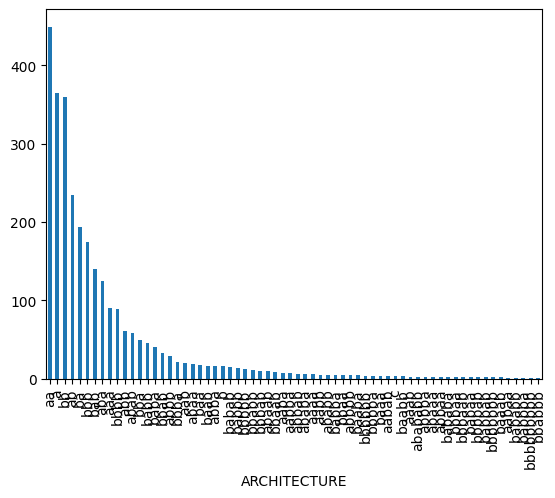

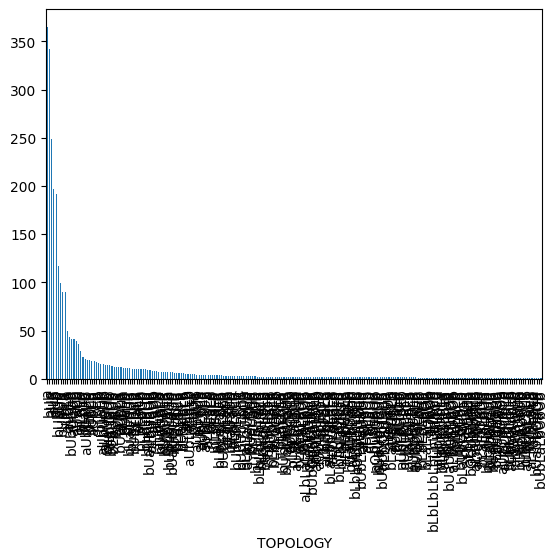

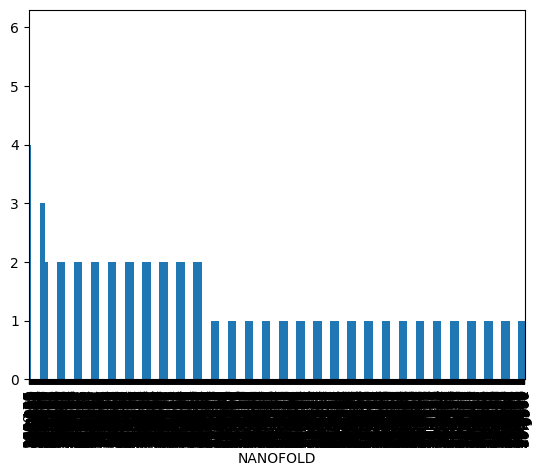

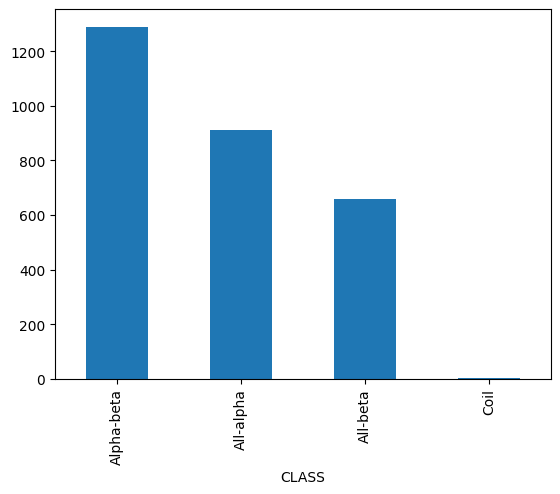

In [234]:
# get data distribution in architecture, topology and nanofold and class

data_class["ARCHITECTURE"].value_counts().plot(kind="bar")
plt.show()
data_class["TOPOLOGY"].value_counts().plot(kind="bar")
plt.show()
data_class["NANOFOLD"].value_counts().plot(kind="bar")
plt.show()
data_class["CLASS"].value_counts().plot(kind="bar")
plt.show()

<Axes: xlabel='NANOFOLD'>

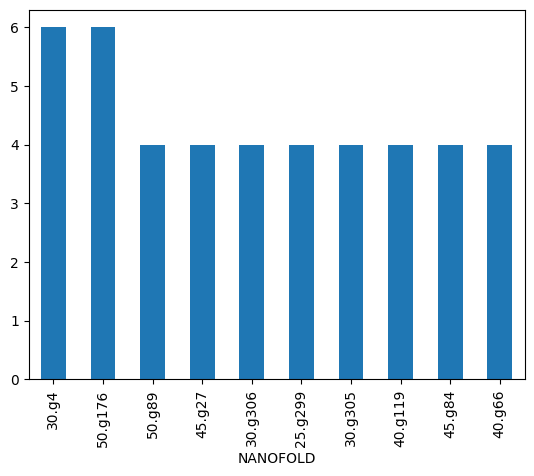

In [235]:
data_class["NANOFOLD"].value_counts()[:10].plot(kind="bar")

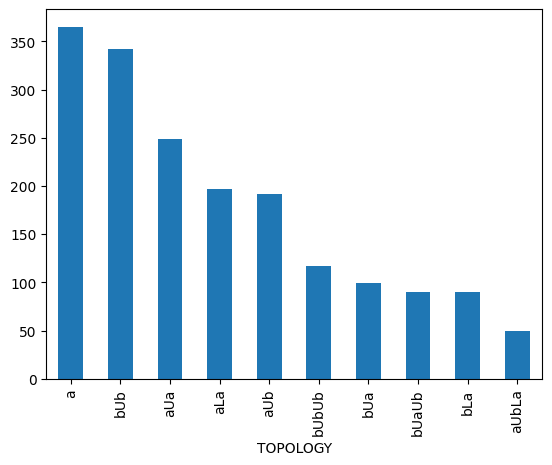

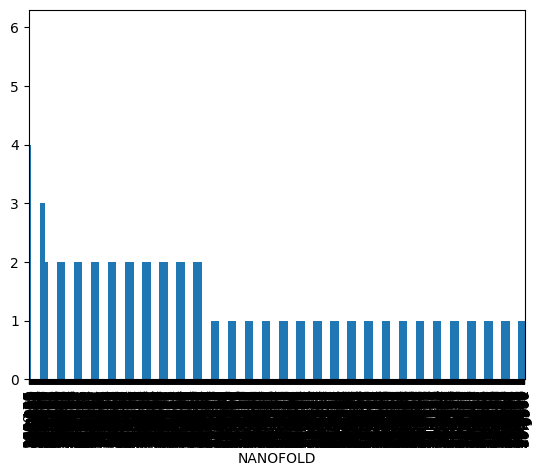

In [236]:
# get top 10 nanofold
data_class["TOPOLOGY"].value_counts()[:10].plot(kind="bar")
plt.show()
data_class["NANOFOLD"].value_counts().plot(kind="bar")
plt.show()

In [237]:
data_class = data_class[
    data_class["TOPOLOGY"].isin(data_class["TOPOLOGY"].value_counts()[:10].index)
]
data_class = data_class[
    data_class["NANOFOLD"].isin(data_class["NANOFOLD"].value_counts()[:10].index)
]

In [238]:
data_class = data_class.reset_index()

In [239]:
# convert continuous to categorical
data_class["ARCHITECTURE"] = data_class["ARCHITECTURE"].astype("category").cat.codes
data_class["TOPOLOGY"] = data_class["TOPOLOGY"].astype("category").cat.codes
data_class["NANOFOLD"] = data_class["NANOFOLD"].astype("category").cat.codes
data_class["CLASS"] = data_class["CLASS"].astype("category").cat.codes

In [240]:
data_class.head()

,index,ARCHITECTURE,TOPOLOGY,NANOFOLD,CLASS,embeddings
0,90,1,1,7,0,"((tf.Tensor(0.028233487, shape=(), dtype=float..."
1,152,5,7,6,2,"((tf.Tensor(0.033097744, shape=(), dtype=float..."
2,242,6,8,4,1,"((tf.Tensor(0.017234936, shape=(), dtype=float..."
3,295,4,6,5,2,"((tf.Tensor(0.060612813, shape=(), dtype=float..."
4,364,1,2,3,0,"((tf.Tensor(0.024584934, shape=(), dtype=float..."


<Axes: xlabel='TOPOLOGY'>

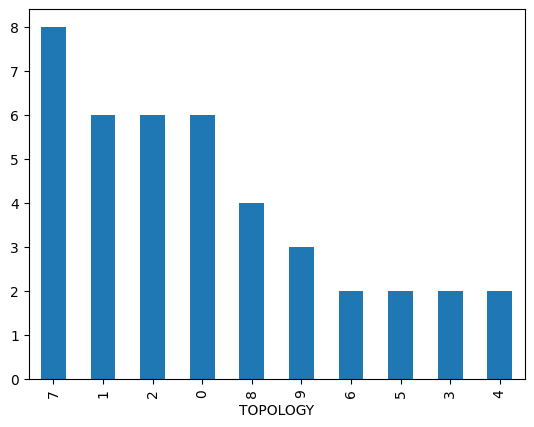

In [244]:
data_class["TOPOLOGY"].value_counts().plot(kind="bar")

<Axes: xlabel='ARCHITECTURE'>

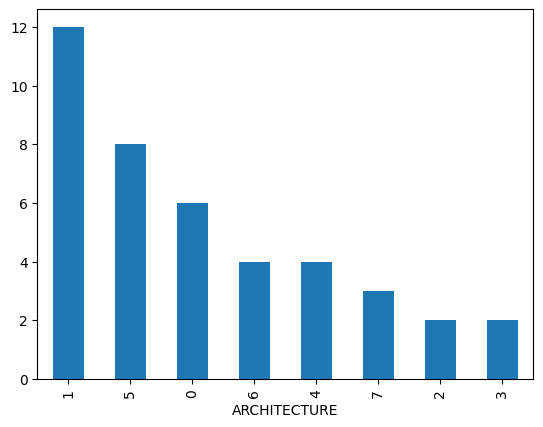

In [304]:
data_class["ARCHITECTURE"].value_counts().plot(kind="bar")

In [291]:
Xtrain_val, Xtest, Ytrain_val, Ytest = train_test_split(
    data_class["embeddings"].values,
    data_class[["CLASS", "ARCHITECTURE", "TOPOLOGY", "NANOFOLD"]].values,
    test_size=0.1,
    random_state=42,
)

In [292]:
Xtrain, xval, Ytrain, yval = train_test_split(
    Xtrain_val, Ytrain_val, test_size=0.2, random_state=42
)

In [320]:
Ytrain.shape

(28, 4)

In [309]:
inputs = tf.keras.layers.Input(shape=(62, 1280))
GRU = tf.keras.layers.GRU(50, return_sequences=True, dropout=0.3)(inputs)
output1 = tf.keras.layers.Dense(4, activation="softmax", name="output1")(GRU)
output2 = tf.keras.layers.Dense(7, activation="softmax", name="output2")(GRU)
output3 = tf.keras.layers.Dense(10, activation="softmax", name="output3")(GRU)
output4 = tf.keras.layers.Dense(10, activation="softmax", name="output4")(GRU)

model_famille = tf.keras.Model(
    inputs=inputs, outputs=[output1, output2, output3, output4]
)
model_famille.summary()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_famille.compile(
    optimizer=optimizer,
    loss={
        "output1": "sparse_categorical_crossentropy",
        "output2": "sparse_categorical_crossentropy",
        "output3": "sparse_categorical_crossentropy",
        "output4": "sparse_categorical_crossentropy",
    },
    metrics=["accuracy"],
)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 62, 1280)]           0         []                            
                                                                                                  
 gru_69 (GRU)                (None, 62, 50)               199800    ['input_40[0][0]']            
                                                                                                  
 output1 (Dense)             (None, 62, 4)                204       ['gru_69[0][0]']              
                                                                                                  
 output2 (Dense)             (None, 62, 7)                357       ['gru_69[0][0]']              
                                                                                            

In [310]:
tf_val_famille = prep_data(list(xval), list(yval), batch_size)
tf_train_famille = prep_data(list(Xtrain), list(Ytrain), batch_size)
tf_test_famille = prep_data(list(Xtest), list(Ytest), batch_size)

In [337]:
callable_famille = tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss")
model_famille.fit(
    tf_train_famille,
    validation_data=tf_val_famille,
    epochs=500,
    batch_size=batch_size,
    callbacks=callable_famille,
)

Epoch 1/500


ValueError: in user code:

    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1131, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py", line 1225, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\metrics\accuracy_metrics.py", line 459, in sparse_categorical_accuracy
        matches = metrics_utils.sparse_categorical_matches(y_true, y_pred)
    File "C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\metrics_utils.py", line 969, in sparse_categorical_matches
        matches = tf.cast(tf.equal(y_true, y_pred), backend.floatx())

    ValueError: Dimensions must be equal, but are 4 and 62 for '{{node Equal}} = Equal[T=DT_FLOAT, incompatible_shape_error=true](Cast_5, Cast_6)' with input shapes: [?,4], [?,62].


In [ ]:
# prendre moins de couche de gru